In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:

def relu_cap(x, b=0):
    return np.clip(x-b, 0, 1)


def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def binary(x, b=0):
    return (x>b).astype(float)

def normalize(x, ax=1):
    return (x - np.mean(x, axis=ax, keepdims=True))/ (1e-8+np.std(x, axis=ax, keepdims=True))

def sigmoid(x, b=0):
    return 1 / (1 + np.exp(-(x-b)))

In [614]:
def run_dynamics(W, inputs,  dt=0.1, divisive_normalization=30.0):
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-divisive_normalization*np.sum(acts, axis=1, keepdims=True)/N_bar*dt) + dt*np.matmul(acts, W)+dt*inputs#*(s==0)
        acts = relu(preacts)# p=p)    
    
    return preacts, acts

In [ ]:
# dx/dt = -cx + J phi(x) + inputs, where c = constant * sum[phi(x)]

In [615]:
def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

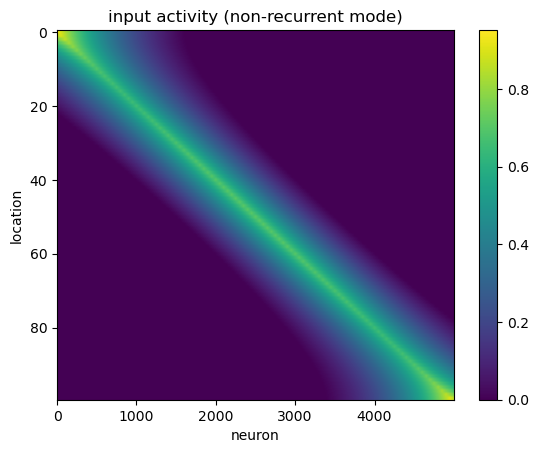

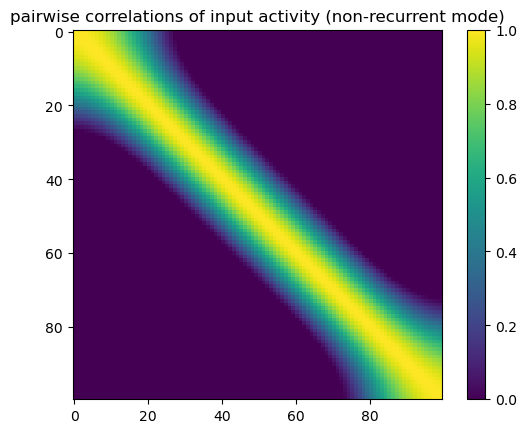

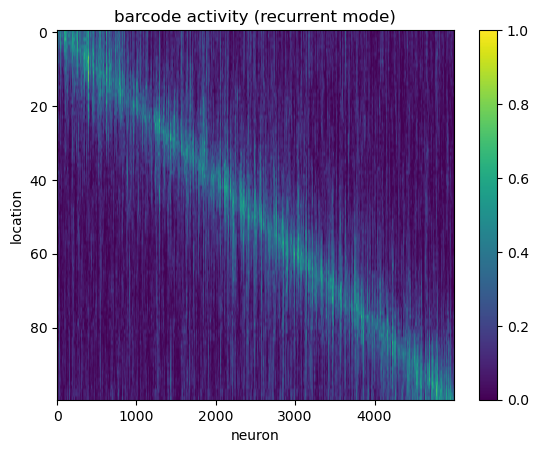

***
sparsity 0.30966


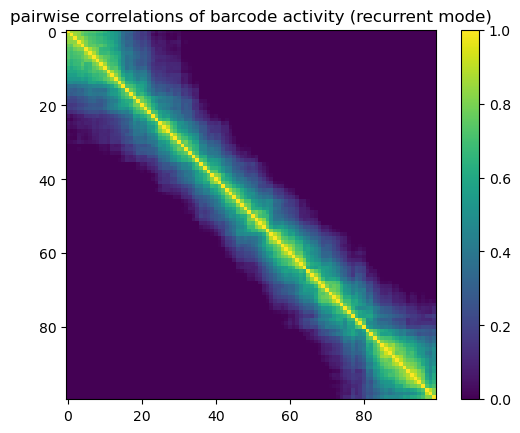

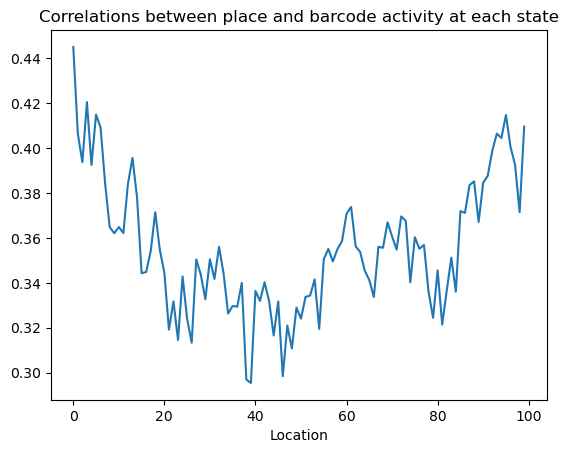

Now I just cached at location: 10


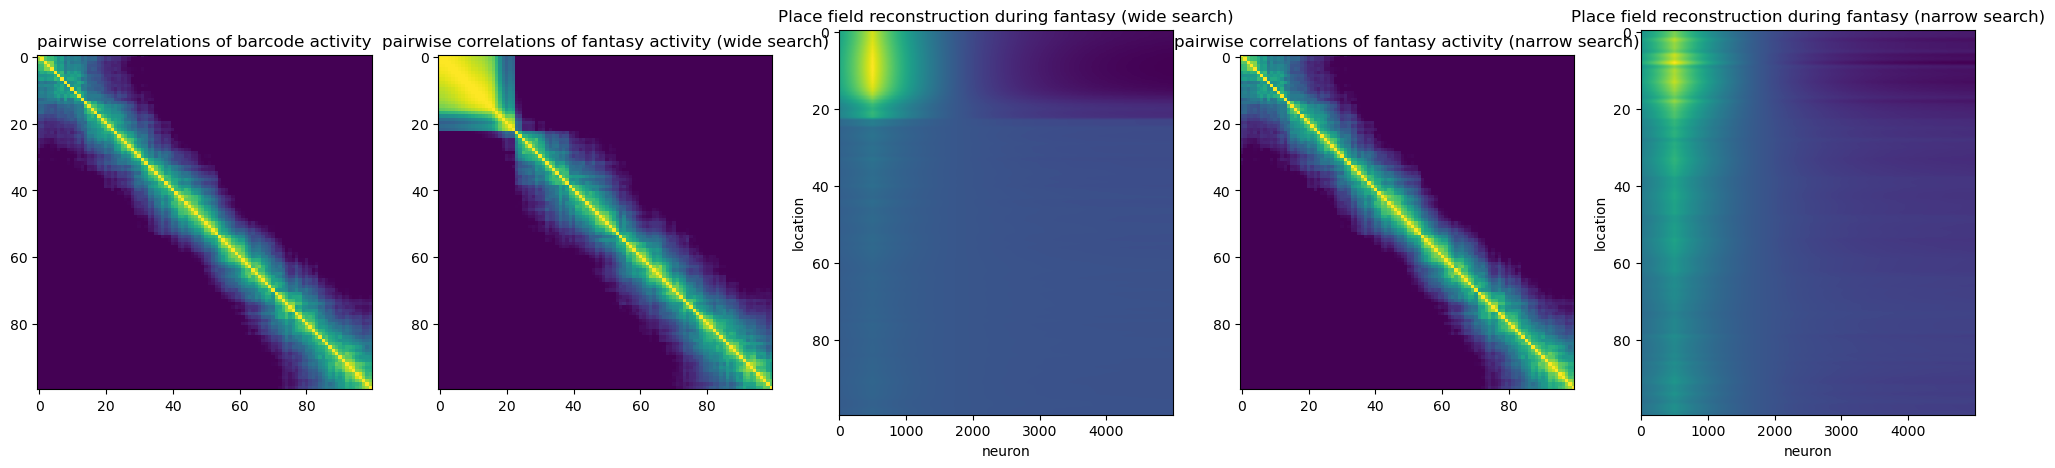

Now I just cached at location: 70


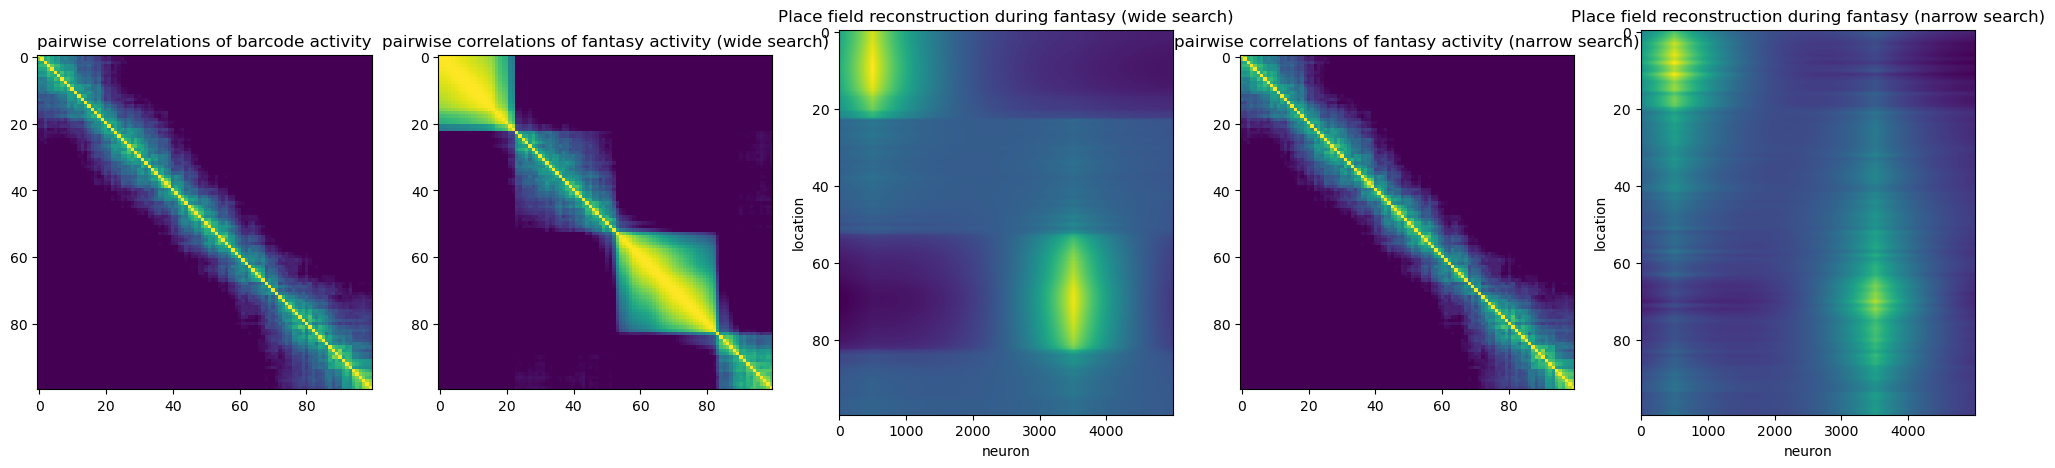

Now I just cached at location: 20


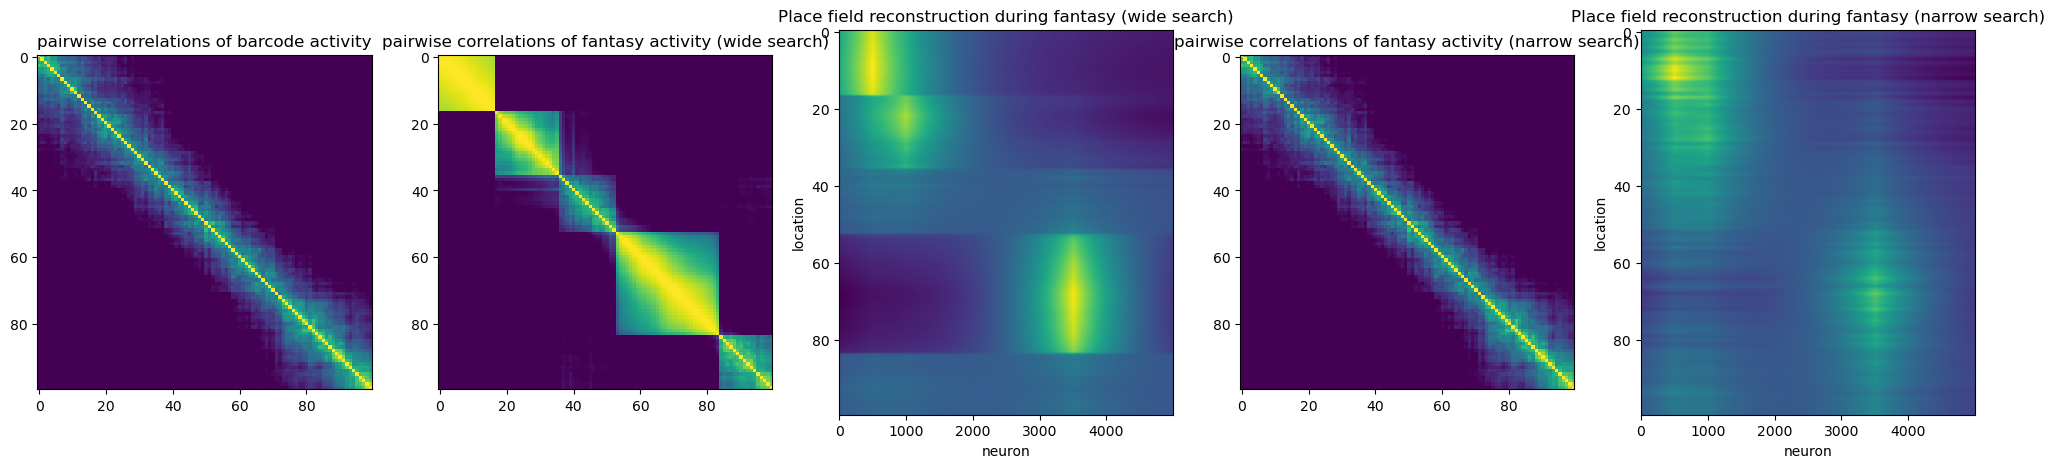

Now I just cached at location: 50


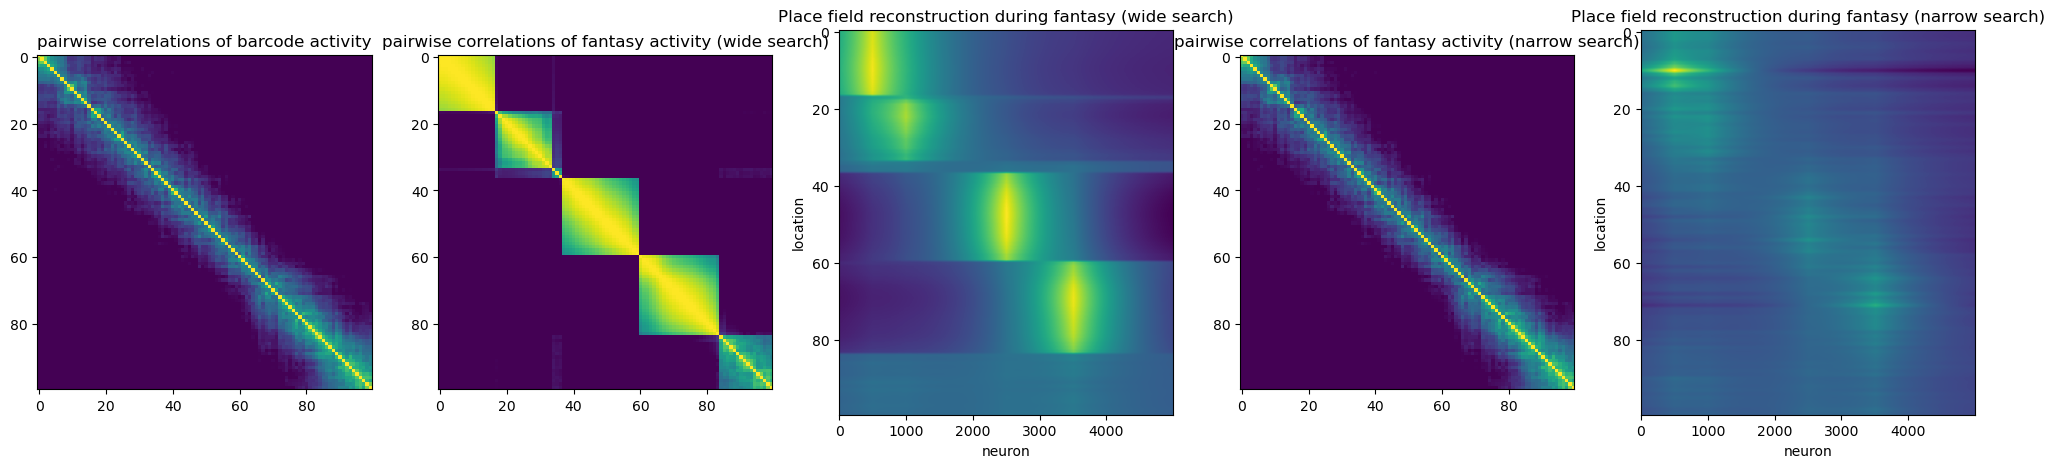

Now I just cached at location: 90


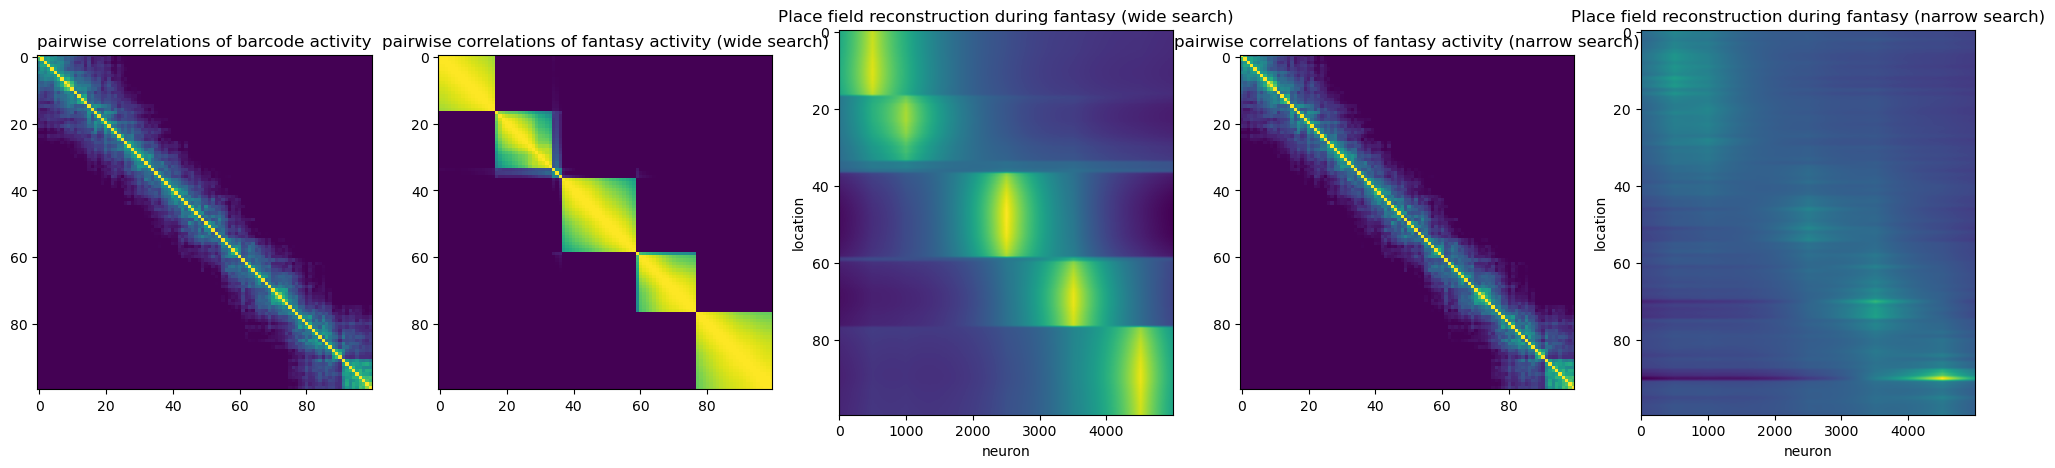

In [617]:
N_inp = 5000
N_bar = 5000

num_states = 100
decay_constant = 0.2
steps = 100
b=10.0
divisive_normalization = 30.0
dt = 0.1

inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        inputs[s, n] = np.exp(-(np.abs(n-peak)/(N_inp*decay_constant)))
inputs = inputs - np.mean(inputs, axis=1, keepdims=True)
inputs = inputs / np.std(inputs, axis=1, keepdims=True)
cache_states = [10, 70, 20, 50, 90]#[20,  60, 30, 70, 90]

rec_strength = 8.0
input_strength = 1.0

W_reconstruct = np.zeros([N_inp, N_bar])
rand_J = np.random.randn(N_bar, N_bar)
#rand_J = np.tril(rand_J) + np.tril(rand_J, -1).T
W_rec = rec_strength*(rand_J / np.sqrt(N_bar)) - (b / N_bar)





W_fantasy = np.zeros([N_bar])

input_preacts, input_acts = run_dynamics(0*W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)# relu_cap_adaptive2(0.0*W_fantasy+acts*(1-time_length) + time_length*np.matmul(acts, W_rec)+time_length*inp_strength*inputs, b=b)# p=p)    


plt.imshow(input_acts, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("input activity (non-recurrent mode)")
plt.show()


plt.imshow(pairwise_correlations_centered(input_acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of input activity (non-recurrent mode)")
plt.show()


preacts, acts = run_dynamics(W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)# relu_cap_adaptive2(0.0*W_fantasy+acts*(1-time_length) + time_length*np.matmul(acts, W_rec)+time_length*inp_strength*inputs, b=b)# p=p)    


plt.imshow(acts, vmin=0, vmax=1, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()

print('***')
print('sparsity', np.mean(acts>0))    
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of barcode activity (recurrent mode)")
plt.show()

acts_normalized = normalize(acts, ax=0)
inputs_normalized = normalize(input_acts, ax=0)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

narrow_search_factor = 0.0
wide_search_factor = 1.0
plasticity_bias = -0.7#-1.5
lr = 40.0#0.1#2.0
for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs, divisive_normalization=divisive_normalization)
    

    

        
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), preact) + np.matmul(np.ones_like(act.transpose())*plasticity_bias, act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)
    
    #W_reconstruct += inputs[cache_state].reshape(-1, 1) @ inputs[cache_state].reshape(1, -1)#acts[cache_state].reshape(1, -1)
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs, divisive_normalization=divisive_normalization) 
    ax[0].set_title("pairwise correlations of barcode activity")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy, divisive_normalization=divisive_normalization) 
    ax[1].set_title("pairwise correlations of fantasy activity (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[2].set_xlabel("neuron")
    ax[2].set_ylabel("location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction during fantasy (wide search)")
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, divisive_normalization=divisive_normalization) 
    ax[3].set_title("pairwise correlations of fantasy activity (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
    

    
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[4].set_xlabel("neuron")
    ax[4].set_ylabel("location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction during fantasy (narrow search)")
    plt.show()
    

In [594]:


preacts, acts = run_dynamics(W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)# relu_cap_adaptive2(0.0*W_fantasy+acts*(1-time_length) + time_length*np.matmul(acts, W_rec)+time_length*inp_strength*inputs, b=b)# p=p)    


In [569]:
input_preacts, input_acts = run_dynamics(0*W_rec, input_strength*inputs+0*W_fantasy, divisive_normalization=divisive_normalization)# relu_cap_adaptive2(0.0*W_fantasy+acts*(1-time_length) + time_length*np.matmul(acts, W_rec)+time_length*inp_strength*inputs, b=b)# p=p)    


In [570]:
preacts.mean(), preacts.std(), acts.mean(), acts.std()

(-1.3327275215410106,
 1.2983481505952408,
 0.09900714756653091,
 0.3175682158047515)

In [571]:
preacts.mean(), preacts.std(), acts.mean(), acts.std(), (acts>0).mean()

(-1.3327275215410106,
 1.2983481505952408,
 0.09900714756653091,
 0.3175682158047515,
 0.15127)

In [572]:
relu(inputs).mean(), relu(inputs).std(), (relu(inputs)>0).mean()

(0.42005743682404517, 0.6892098110842398, 0.394324)

In [573]:
(acts[acts>0].mean()),  (relu(inputs)[relu(inputs)>0].mean())

(0.6545061649139348, 1.065259626155256)

In [618]:
input_acts[input_acts>0].mean(), acts[acts>0].mean()

(0.3000596594176389, 0.5485633660272388)

In [595]:
(input_acts>0).mean(), (acts>0).mean()

(0.394324, 0.308044)

In [621]:
scale = 0.1
print(np.mean([np.corrcoef(poisson(scale*input_acts[i]).rvs(), poisson(scale*input_acts[i]).rvs())[0, 1] for i in range(100)]))
print(np.mean([np.corrcoef(poisson(scale*acts[i]).rvs(), poisson(scale*acts[i]).rvs())[0, 1] for i in range(100)]))

0.03325680800215456
0.08061945074320631


In [609]:
import numpy as np
from scipy.stats import poisson, nbinom

In [610]:
p = 0.1
print(np.mean([np.corrcoef(nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+input_acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))
print(np.mean([np.corrcoef(nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs(), nbinom(1e-8+acts[i] / (1.0/p - 1.0), p).rvs())[0, 1] for i in range(100)]))

0.02991933420637841
0.0949374362073169


0.08403050470130692

In [581]:
 nbinom(input_acts[0] / (1.0/p - 1.0), input_acts[0])